In [ ]:
!pip install mtcnn lz4 opencv-python scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Détection de visages
from mtcnn import MTCNN

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import datetime



In [ ]:
# --- Téléchargement et décompression du dataset ---
#!rm -rf /content/FER2013
#!kaggle datasets download msambare/fer2013 -p /content/FER2013
#!unzip -q /content/FER2013/fer2013.zip -d /content/FER2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 94% 57.0M/60.3M [00:02<00:00, 40.9MB/s]
100% 60.3M/60.3M [00:02<00:00, 29.3MB/s]


### 2) Détection et Recadrage des Visages (prétraitement hors-ligne)

In [ ]:

# Chemins vers les dossiers originaux
data_dir_train = '/content/FER2013/train'
data_dir_test  = '/content/FER2013/test'

# Nouveaux dossiers de sortie où seront sauvegardées les images recadrées
cropped_train_dir = '/content/cropped_train'
cropped_test_dir  = '/content/cropped_test'

In [ ]:


detector = MTCNN()

def detect_and_crop_face(image_path, output_path, upscale_factor=1):
    """
    Ouvre une image, détecte le visage principal et recadre.
    Sauvegarde l'image recadrée dans output_path.
    upscale_factor peut être utilisé si la résolution est trop basse.
    """
    img = cv2.imread(image_path)
    if img is None:
        return  # image non lisible

    # Optionnel : agrandir l'image si elle est très petite
    if upscale_factor > 1:
        h, w = img.shape[:2]
        img = cv2.resize(img, (w*upscale_factor, h*upscale_factor))

    # Détection des visages
    faces = detector.detect_faces(img)

    if len(faces) > 0:
        # Prendre la bounding box du premier visage
        x, y, w, h = faces[0]['box']
        # Si on a agrandi l'image, ramener à l'échelle d'origine
        if upscale_factor > 1:
            x = x // upscale_factor
            y = y // upscale_factor
            w = w // upscale_factor
            h = h // upscale_factor

        # Recadrer
        original_img = cv2.imread(image_path)  # relire l'image d'origine
        h_orig, w_orig = original_img.shape[:2]
        # borne de sécurité
        x = max(0, x)
        y = max(0, y)
        x2 = min(x + w, w_orig)
        y2 = min(y + h, h_orig)
        face_crop = original_img[y:y2, x:x2]
    else:
        # Aucun visage détecté => on garde l'image telle quelle
        face_crop = cv2.imread(image_path)
        if face_crop is None:
            return

    # Sauvegarde
    cv2.imwrite(output_path, face_crop)

def process_directory(input_dir, output_dir):
    """
    Parcourt input_dir (sous-dossiers = classes),
    recadre chaque image, puis sauvegarde dans output_dir
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)

        for img_file in os.listdir(class_input_path):
            input_img_path = os.path.join(class_input_path, img_file)
            output_img_path = os.path.join(class_output_path, img_file)
            detect_and_crop_face(input_img_path, output_img_path, upscale_factor=1)

# Appliquer sur train et test
process_directory(data_dir_train, cropped_train_dir)
process_directory(data_dir_test, cropped_test_dir)


### 3) Préparation des données (flow_from_directory)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (299, 299)  # InceptionV3 attend des images 299x299
cropped_train_dir = '/content/cropped_train'
cropped_test_dir  = '/content/cropped_test'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% pour la validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=cropped_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    directory=cropped_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    directory=cropped_test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)



Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### 4) Entraînement avec InceptionV3 + Fine-Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# 1) Construction du modèle
base_inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
# Geler temporairement toutes les couches
for layer in base_inception.layers:
    layer.trainable = False

x = base_inception.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes d'émotions

model_inception = Model(inputs=base_inception.input, outputs=predictions)

# 2) Compilation
model_inception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2.1)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_inception.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# (Optionnel) TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stop, reduce_lr, checkpoint, tensorboard_cb]


# 3) Entraînement initial (base gelée)
history_initial = model_inception.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.2083 - loss: 1.9820
Epoch 1: val_loss improved from inf to 1.65352, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 604s 812ms/step - accuracy: 0.2083 - loss: 1.9819 - val_accuracy: 0.3487 - val_loss: 1.6535 - learning_rate: 1.0000e-04
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.3173 - loss: 1.7419
Epoch 2: val_loss improved from 1.65352 to 1.58573, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 567s 790ms/step - accuracy: 0.3173 - loss: 1.7419 - val_accuracy: 0.3719 - val_loss: 1.5857 - learning_rate: 1.0000e-04
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.3566 - loss: 1.6553
Epoch 3: val_loss improved from 1.58573 to 1.53714, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 564s 786ms/step - accuracy: 0.3567 - loss: 1.6553 - val_accuracy: 0.3982 - val_loss: 1.5371 - learning_rate: 1.0000e-04
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.3766 - loss: 1.6055
Epoch 4: val_loss improved from 1.53714 to 1.51461, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 620s 783ms/step - accuracy: 0.3766 - loss: 1.6055 - val_accuracy: 0.4142 - val_loss: 1.5146 - learning_rate: 1.0000e-04
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.3966 - loss: 1.5749
Epoch 5: val_loss improved from 1.51461 to 1.49550, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 566s 787ms/step - accuracy: 0.3966 - loss: 1.5749 - val_accuracy: 0.4268 - val_loss: 1.4955 - learning_rate: 1.0000e-04
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.4054 - loss: 1.5520
Epoch 6: val_loss improved from 1.49550 to 1.47728, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 553s 770ms/step - accuracy: 0.4054 - loss: 1.5520 - val_accuracy: 0.4264 - val_loss: 1.4773 - learning_rate: 1.0000e-04
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.4113 - loss: 1.5339
Epoch 7: val_loss improved from 1.47728 to 1.47089, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 589s 821ms/step - accuracy: 0.4113 - loss: 1.5339 - val_accuracy: 0.4342 - val_loss: 1.4709 - learning_rate: 1.0000e-04
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4135 - loss: 1.5272
Epoch 8: val_loss improved from 1.47089 to 1.46756, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 563s 784ms/step - accuracy: 0.4135 - loss: 1.5272 - val_accuracy: 0.4383 - val_loss: 1.4676 - learning_rate: 1.0000e-04
Epoch 9/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4202 - loss: 1.5063
Epoch 9: val_loss improved from 1.46756 to 1.46137, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 588s 819ms/step - accuracy: 0.4202 - loss: 1.5063 - val_accuracy: 0.4281 - val_loss: 1.4614 - learning_rate: 1.0000e-04
Epoch 10/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.4317 - loss: 1.4836
Epoch 10: val_loss improved from 1.46137 to 1.44807, saving model to best_inception.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 562s 783ms/step - accuracy: 0.4317 - loss: 1.4836 - val_accuracy: 0.4499 - val_loss: 1.4481 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.
Epoch 1/20
414/718 ━━━━━━━━━━━━━━━━━━━━ 3:19 655ms/step - accuracy: 0.3512 - loss: 1.6680

KeyboardInterrupt: 

In [ ]:

# 5) Évaluation sur le test set
loss, acc = model_inception.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.5033 - loss: 1.3199
Test Accuracy: 49.55%


In [ ]:

# 1) Recréer le même modèle (structure identique) :
base_inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
for layer in base_inception.layers:
    layer.trainable = False

x = base_inception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes
model_inception = Model(inputs=base_inception.input, outputs=predictions)

model_inception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) Charger les poids du checkpoint, si vous en avez un
model_inception.load_weights('best_inception.h5')  # facultatif si vous voulez repartir du meilleur checkpoint
print("Poids du modèle chargés depuis best_inception.h5")

############################################################################
# B) Fine-tuning : dégeler partiellement la base Inception
############################################################################
# Exemple : dégeler à partir de la couche 200 (à adapter selon votre architecture)
fine_tune_start = 200
for layer in base_inception.layers[:fine_tune_start]:
    layer.trainable = False
for layer in base_inception.layers[fine_tune_start:]:
    layer.trainable = True

# Re-compiler le modèle avec un LR plus faible
model_inception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # LR réduit
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Définir ou réutiliser vos callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(
    'best_inception_finetuned.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
log_dir = "logs/fit_finetune/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, reduce_lr, checkpoint, tensorboard_cb]

############################################################################
# C) Continuer l’entraînement (fine-tuning)
############################################################################
history_finetune = model_inception.fit(
    train_generator,
    epochs=10,  # vous pouvez ajuster
    validation_data=validation_generator,
    callbacks=callbacks
)



Poids du modèle chargés depuis best_inception.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.3697 - loss: 1.6179
Epoch 1: val_loss improved from inf to 1.27615, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 739s 966ms/step - accuracy: 0.3698 - loss: 1.6178 - val_accuracy: 0.5156 - val_loss: 1.2762 - learning_rate: 1.0000e-05
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.5100 - loss: 1.2998
Epoch 2: val_loss improved from 1.27615 to 1.19089, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 689s 959ms/step - accuracy: 0.5100 - loss: 1.2998 - val_accuracy: 0.5509 - val_loss: 1.1909 - learning_rate: 1.0000e-05
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5561 - loss: 1.1816
Epoch 3: val_loss improved from 1.19089 to 1.14935, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 760s 985ms/step - accuracy: 0.5561 - loss: 1.1816 - val_accuracy: 0.5689 - val_loss: 1.1494 - learning_rate: 1.0000e-05
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.5913 - loss: 1.0905
Epoch 4: val_loss improved from 1.14935 to 1.11758, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 699s 974ms/step - accuracy: 0.5913 - loss: 1.0905 - val_accuracy: 0.5827 - val_loss: 1.1176 - learning_rate: 1.0000e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.6170 - loss: 1.0277
Epoch 5: val_loss improved from 1.11758 to 1.08828, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 699s 915ms/step - accuracy: 0.6170 - loss: 1.0277 - val_accuracy: 0.5910 - val_loss: 1.0883 - learning_rate: 1.0000e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.6425 - loss: 0.9518
Epoch 6: val_loss improved from 1.08828 to 1.06869, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 635s 884ms/step - accuracy: 0.6425 - loss: 0.9518 - val_accuracy: 0.6027 - val_loss: 1.0687 - learning_rate: 1.0000e-05
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.6726 - loss: 0.8888
Epoch 7: val_loss improved from 1.06869 to 1.06434, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 622s 867ms/step - accuracy: 0.6726 - loss: 0.8888 - val_accuracy: 0.6036 - val_loss: 1.0643 - learning_rate: 1.0000e-05
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.6919 - loss: 0.8343
Epoch 8: val_loss improved from 1.06434 to 1.06313, saving model to best_inception_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 648s 902ms/step - accuracy: 0.6919 - loss: 0.8343 - val_accuracy: 0.6173 - val_loss: 1.0631 - learning_rate: 1.0000e-05
Epoch 9/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.7141 - loss: 0.7802
Epoch 9: val_loss did not improve from 1.06313
718/718 ━━━━━━━━━━━━━━━━━━━━ 626s 872ms/step - accuracy: 0.7141 - loss: 0.7802 - val_accuracy: 0.6154 - val_loss: 1.0661 - learning_rate: 1.0000e-05
Epoch 10/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.7330 - loss: 0.7208
Epoch 10: val_loss did not improve from 1.06313
718/718 ━━━━━━━━━━━━━━━━━━━━ 627s 873ms/step - accuracy: 0.7330 - loss: 0.7208 - val_accuracy: 0.6227 - val_loss: 1.0743 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 8.


In [ ]:

############################################################################
# D) Évaluation finale
############################################################################
loss_test, acc_test = model_inception.evaluate(test_generator)
print(f"Test Accuracy after fine-tuning: {acc_test*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.6272 - loss: 1.0396
Test Accuracy after fine-tuning: 63.40%


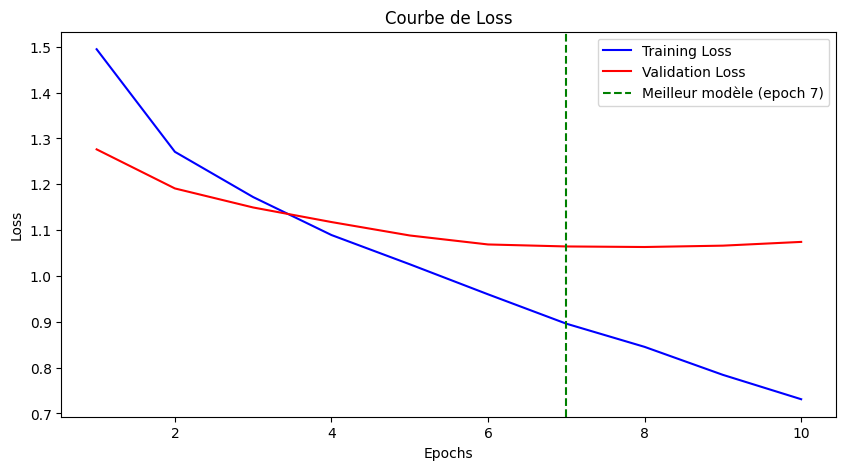

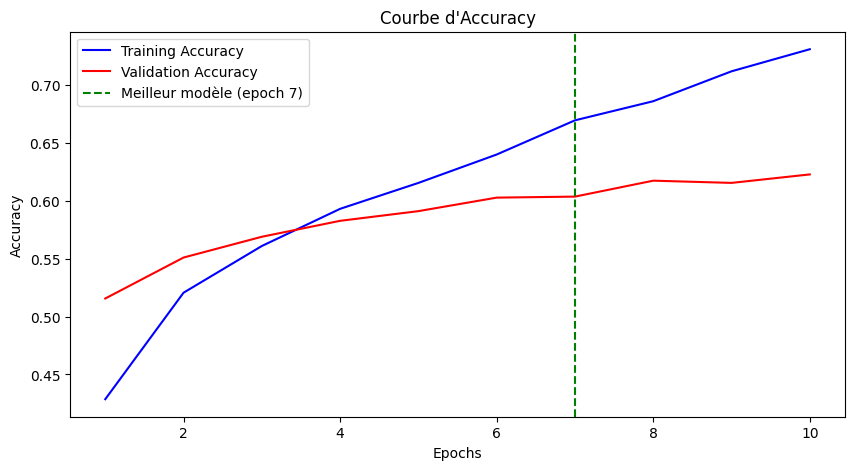

In [ ]:
import matplotlib.pyplot as plt

# Extraction des métriques d'entraînement à partir de l'historique
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
accuracy = history_finetune.history['accuracy']
val_accuracy = history_finetune.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Définissez ici l'époque correspondant au meilleur modèle
# Par exemple, si c'est l'époque 7, utilisez :
best_epoch = 7

# Affichage de la courbe de loss (entraînement et validation) avec ligne verticale
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axvline(x=best_epoch, color='g', linestyle='--',
            label=f'Meilleur modèle (epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()

# Affichage de la courbe d'accuracy (entraînement et validation) avec ligne verticale
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.axvline(x=best_epoch, color='g', linestyle='--',
            label=f'Meilleur modèle (epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Courbe d'Accuracy")
plt.legend()
plt.show()


In [ ]:
# Test du model fine tunning
loss_test, acc_test = model_inception.evaluate(test_generator)
print(f"Test Accuracy: {acc_test*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.6370 - loss: 0.9952
Test Accuracy: 63.40%


### 5) Extraction des Features pour SVM

#### A) Extraction des features

In [ ]:
import numpy as np
from sklearn.svm import SVC

# 1) Créer un modèle "features_model" qui sort avant la couche Dense(7, softmax)
features_model = Model(
    inputs=model_inception.input,
    outputs=model_inception.layers[-2].output  # la couche juste avant Dense(7)
)

# 2) Extraire les features pour le train set
train_features = []
train_labels = []

# Remarque : on peut itérer sur train_generator (ou un flow similaire) pour récupérer toutes les images
train_generator.reset()
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)  # Au lieu de train_generator.next()
    feats = features_model.predict(x_batch)
    train_features.append(feats)
    train_labels.append(y_batch)

train_features = np.concatenate(train_features, axis=0)
train_labels   = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []

test_generator.reset()
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)  # Au lieu de test_generator.next()
    feats = features_model.predict(x_batch)
    test_features.append(feats)
    test_labels.append(y_batch)

test_features = np.concatenate(test_features, axis=0)
test_labels   = np.concatenate(test_labels, axis=0)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

#### B) Entraînement d’un SVM

In [ ]:
train_labels_idx = np.argmax(train_labels, axis=1)
test_labels_idx  = np.argmax(test_labels, axis=1)


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import joblib

parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svc = SVC()

clf = GridSearchCV(
    svc,
    param_grid=parameters,
    scoring='accuracy',
    cv=5,            # 5-fold cross-validation
    verbose=1,
    n_jobs=-1        # utilise tous les CPU
)

clf.fit(train_features, train_labels_idx)

print("Meilleurs hyperparamètres :", clf.best_params_)
print("Meilleure précision en cross-validation :", clf.best_score_)

best_svm = clf.best_estimator_
joblib.dump(best_svm, "svm_best.joblib")
print("Meilleur SVM sauvegardé dans svm_best.joblib")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs hyperparamètres : {'C': 1, 'kernel': 'rbf'}
Meilleure précision en cross-validation : 0.7573145938326205
Meilleur SVM sauvegardé dans svm_best.joblib


In [23]:
from sklearn.model_selection import learning_curve
# Calcul de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    best_svm,               # Votre modèle SVM déjà entraîné (meilleur modèle)
    train_features,         # Les features d'entraînement
    train_labels_idx,       # Les labels d'entraînement sous forme d'indices
    cv=5,                   # Cross-validation à 5 folds
    n_jobs=-1,              # Utilisation de tous les CPU
    train_sizes=np.linspace(0.1, 1.0, 10),  # Différents pourcentages de données
    verbose=1
)

# Moyenne et écart-type des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# Affichage de la courbe d'apprentissage
plt.figure(figsize=(8, 6))
plt.title("Learning Curve du SVM")
plt.xlabel("Nombre d'exemples d'entraînement")
plt.ylabel("Précision")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Précision sur l'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Précision en cross-validation")

plt.legend(loc="best")
plt.show()

[learning_curve] Training set sizes: [ 1837  3674  5512  7349  9187 11024 12861 14699 16536 18374]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

### Function pour sauvegarde de la session

In [ ]:
import zipfile
import os

def zip_folders(zip_filename, folders):
    """
    Zipe plusieurs dossiers dans une archive zip.

    Parameters:
    - zip_filename : nom (et chemin) du fichier zip de sortie.
    - folders : liste de chemins vers les dossiers à zipper.
    """
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in folders:
            # On parcourt tout le dossier et on ajoute les fichiers
            for root, _, files in os.walk(folder):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Pour garder la structure, on inclut le nom du dossier de base
                    arcname = os.path.join(os.path.basename(folder), os.path.relpath(file_path, folder))
                    zipf.write(file_path, arcname)

# Liste des dossiers à zipper
folders_to_zip = ['/content/cropped_train', '/content/cropped_test']

# Nom et chemin du fichier zip de sortie
output_zip_file = '/content/dataset.zip'

zip_folders(output_zip_file, folders_to_zip)
print(f"Les dossiers ont été zippés dans : {output_zip_file}")


In [ ]:
import zipfile
import os

def unzip_file(zip_filepath, extract_dir):
    """
    Extrait le contenu d'une archive zip dans le dossier spécifié.
    Vérifie d'abord si le fichier est une archive zip valide.

    Parameters:
    - zip_filepath : chemin complet vers le fichier zip.
    - extract_dir  : dossier de destination pour l'extraction.
    """
    # Vérifier si le fichier est bien une archive zip
    if not zipfile.is_zipfile(zip_filepath):
        print(f"Erreur : Le fichier '{zip_filepath}' n'est pas une archive zip valide.")
        return

    # Créer le dossier de destination s'il n'existe pas
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    try:
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extraction terminée dans le dossier : {extract_dir}")
    except zipfile.BadZipFile as e:
        print("Erreur lors de l'ouverture du fichier zip :", e)

# Chemin vers le fichier zip à extraire
zip_file_path = '/content/dataset.zip'
# Dossier de destination pour l'extraction
destination_folder = '/content'

# Exécution de la fonction pour dézipper
unzip_file(zip_file_path, destination_folder)


Extraction terminée dans le dossier : /content
